# MNIST Prediction with Convolutional Neural Network

- MNIST dataset: is a dataset of 60,000 28x28 grayscale images of the 10 digits, along with a test set of 10,000 images. More info can be found at the [MNIST homepage](http://yann.lecun.com/exdb/mnist/).
- Goal: build a simple artificial neural network to predict the digit in the images.

#### Import libraries

In [19]:
# numpy for linear algebra
import numpy as np

# matplotlib for plotting the images, loss and accuracy
import matplotlib.pyplot as plt


# tqdm for progress bar
from tqdm import tqdm

# scipy for convolve2d function
from scipy import signal

# keras for mnist dataset
from keras import datasets

#### 1. Libs 

##### 1.1. Base Layer class

The base layer class is the parent class of all layers in the network. It has the following methods:
- `forward`: forward pass of the layer
- `backpropagation`: backward pass of the layer

In [20]:
class BaseLayer:
    def __init__(self) -> None:
        self.input = None
        self.output = None

    def forward(self, X: np.ndarray) -> np.ndarray:
        """
        :param X: input data

        TODO: return the output of the layer
        """
        pass

    def backpropagation(self, dZ: np.ndarray, lr: float) -> np.ndarray:
        """
        :param dZ: gradient of the loss with respect to the output of the layer
        :param lr: learning rate

        TODO: update parameters and return the gradient of the input
        """
        pass

##### 1.2. Weight Initialization

The weight initialization class has the following methods:

- `zeros`: initialize weights with zeros
- `ones`: initialize weights with ones
- `random`: initialize weights with random values
- `random uniform`: initialize weights with random values from a uniform distribution

In [21]:
class WeightInitializer:
    def __init__(self, inp_size: int, out_size: int, act_type: str = None) -> None:
        """
        :param inp_size: input size of the layer
        :param out_size: output size of the layer
        :param act_type: type of the activation function to be used (zeros, ones, random, random_uniform)
        """
        if act_type is None:
            self.act_type = "random"
        else:
            self.act_type = act_type

        self.inp_size = inp_size
        self.out_size = out_size

    def zeros(self) -> np.ndarray:
        return np.zeros(shape=(self.out_size, self.inp_size))

    def ones(self) -> np.ndarray:
        return np.ones(shape=(self.out_size, self.inp_size))

    def random(self) -> np.ndarray:
        return np.random.randn(self.out_size, self.inp_size)

    def random_uniform(self) -> np.ndarray:
        return np.random.uniform(-1, 1, (self.out_size, self.inp_size))

    def get(self) -> np.ndarray:
        if self.act_type == "zeros":
            return self.zeros()
        elif self.act_type == "ones":
            return self.ones()
        elif self.act_type == "random":
            return self.random()
        elif self.act_type == "random_uniform":
            return self.random_uniform()
        else:
            raise ValueError("Invalid activation type")

##### 1.3. Cost Function

The cost function class has the following methods:

- `mean squared error`: mean squared error cost function: $C = \frac{1}{2n} \sum_x ||y - a||^2$
- `binary cross entropy`: binary cross entropy cost function: $C = -\frac{1}{n} \sum_x [y \ln a + (1 - y) \ln (1 - a)]$

In [22]:
class Cost:
    def __init__(self, cost_type: str = "mse") -> None:
        """
        :param cost_type: type of cost function to use (mse, cross_entropy)
        """
        self.cost_type = cost_type

    def mse(self, y_true: np.ndarray, y_pred: np.ndarray) -> np.ndarray:
        """
        :param y_true: true values
        :param y_pred: predicted values
        """
        return np.mean((y_true - y_pred) ** 2)

    def d_mse(self, y_true: np.ndarray, y_pred: np.ndarray) -> np.ndarray:
        """
        :param y_true: true values
        :param y_pred: predicted values
        """
        return 2 * (y_pred - y_true) / np.size(y_true)

    def cross_entropy(self, y_true: np.ndarray, y_pred: np.ndarray) -> np.ndarray:
        """
        :param y_true: true values
        :param y_pred: predicted values
        """
        return -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

    def d_cross_entropy(self, y_true: np.ndarray, y_pred: np.ndarray) -> np.ndarray:
        """
        :param y_true: true values
        :param y_pred: predicted values
        """
        return ((1 - y_true) / (1 - y_pred) - y_true / y_pred) / np.size(y_true)

    def get_cost(self, y_true: np.ndarray, y_pred: np.ndarray) -> np.ndarray:
        if self.cost_type == "mse":
            return self.mse(y_true, y_pred)
        elif self.cost_type == "cross_entropy":
            return self.cross_entropy(y_true, y_pred)
        else:
            raise ValueError("Invalid cost type")

    def get_d_cost(self, y_true: np.ndarray, y_pred: np.ndarray) -> np.ndarray:
        if self.cost_type == "mse":
            return self.d_mse(y_true, y_pred)
        elif self.cost_type == "cross_entropy":
            return self.d_cross_entropy(y_true, y_pred)
        else:
            raise ValueError("Invalid cost type")

##### 1.4. Plotting function
The plotting functions is used to plot the images and its true labels and predicted labels.

In [23]:
def plot_data(
    X: np.ndarray,
    y: np.ndarray,
    y_proba: np.ndarray = None,
    shape: tuple[int, int] = (2, 4),
) -> None:
    """
    :param X: input data (images)
    :param y: true labels
    :param y_proba: predicted labels
    :param shape: shape of the plot (nrows, ncols)
    """
    nrows, ncols = shape
    _, axes = plt.subplots(nrows, ncols, figsize=(10, 5))

    len_x = X.shape[0]
    for idx in range(nrows * ncols):
        ax = axes[idx // ncols, idx % ncols]

        img_idx = np.random.randint(0, len_x)

        ax.imshow(X[img_idx], cmap="gray")
        ax.set(xticks=[], yticks=[])

        true_label = f"True: {y[img_idx]}"
        color = "black"

        if y_proba is not None:
            pred_label = f"Pred: {y_proba[img_idx]}"
            color = "green" if y[img_idx] == y_proba[img_idx] else "red"

        img_title = true_label if y_proba is None else f"{true_label}\n{pred_label}"
        ax.set_xlabel(img_title, color=color)

    plt.tight_layout()
    plt.show()

#### 2. Layers

##### 2.1. Convolutional Layer

In [24]:
class Conv2D(BaseLayer):
    def __init__(
        self, inp_shape: tuple[int, int, int], kernel_size: int = 3, depth: int = 1
    ):
        """
        :param inp_shape: shape of the input data
        :param kernel_size: size of the kernel
        :param depth: depth of the output data
        """
        inp_depth, inp_height, inp_width = inp_shape
        self.depth = depth
        self.inp_shape = inp_shape
        self.inp_depth = inp_depth

        self.out_shape = (
            depth,
            inp_height - kernel_size + 1,
            inp_width - kernel_size + 1,
        )
        self.kernels_shape = (depth, inp_depth, kernel_size, kernel_size)
        self.kernels = np.random.randn(*self.kernels_shape)
        self.bias = np.random.randn(*self.out_shape)

    def forward(self, X: np.ndarray) -> np.ndarray:
        self.X = X
        self.output = np.copy(self.bias)

        for row in range(self.depth):
            for col in range(self.inp_depth):
                self.output[row] += signal.convolve2d(
                    self.X[col], self.kernels[row, col], mode="valid"
                )

        return self.output

    def backpropagation(self, dZ: np.ndarray, lr: float) -> np.ndarray:
        dK = np.zeros(self.kernels_shape)
        dX = np.zeros(self.inp_shape)

        for row in range(self.depth):
            for col in range(self.inp_depth):
                dK[row, col] = signal.convolve2d(self.X[col], dZ[row], mode="valid")
                dX[col] += signal.convolve2d(
                    dZ[row], self.kernels[row, col], mode="full"
                )
        self.kernels -= lr * dK
        self.bias -= lr * dZ
        return dX

##### 2.2. Dense Layer class

In [25]:
class Dense(BaseLayer):
    def __init__(self, inp_size: int, out_size: int) -> None:
        """
        :param inp_size: input size of the layer
        :param out_size: output size of the layer
        """
        self.weights = WeightInitializer(inp_size, out_size).get()
        self.bias = WeightInitializer(1, out_size).get()

    def forward(self, X: np.ndarray) -> np.ndarray:
        self.X = X
        return np.dot(self.weights, self.X) + self.bias

    def backpropagation(self, dZ: np.ndarray, lr: float) -> np.ndarray:
        dW = np.dot(dZ, self.X.T)
        self.weights -= lr * dW
        self.bias -= lr * dZ
        return np.dot(self.weights.T, dZ)

##### 2.3. Activation Layer class

- `linear`: linear activation function $f(x) = x$
- `reLU`: rectified linear unit activation function $f(x) = max(0, x)$
- `sigmoid`: sigmoid activation function $f(x) = \frac{1}{1 + e^{-x}}$
- `tanh`: hyperbolic tangent activation function $f(x) = \frac{e^x - e^{-x}}{e^x + e^{-x}}$

In [26]:
class Activation(BaseLayer):
    def __init__(self, act_type: str = "reLU") -> None:
        """
        :param act_type: type of the activation function to be used (linear, reLU, sigmoid, tanh)
        """
        self.act_type = act_type

    def linear(self, X: np.ndarray) -> np.ndarray:
        return X

    def d_linear(self, X: np.ndarray) -> np.ndarray:
        return 1

    def reLU(self, X: np.ndarray) -> np.ndarray:
        return np.maximum(0, X)

    def d_reLU(self, X: np.ndarray) -> np.ndarray:
        return np.where(X > 0, 1, 0)

    def sigmoid(self, X: np.ndarray) -> np.ndarray:
        return 1 / (1 + np.exp(-X))

    def d_sigmoid(self, X: np.ndarray) -> np.ndarray:
        return self.sigmoid(X) * (1 - self.sigmoid(X))

    def tanh(self, X: np.ndarray) -> np.ndarray:
        return np.tanh(X)

    def d_tanh(self, X: np.ndarray) -> np.ndarray:
        return 1 - np.tanh(X) ** 2

    def get_activation(self, X: np.ndarray) -> np.ndarray:
        if self.act_type == "linear":
            return self.linear(X)
        elif self.act_type == "reLU":
            return self.reLU(X)
        elif self.act_type == "sigmoid":
            return self.sigmoid(X)
        elif self.act_type == "tanh":
            return self.tanh(X)
        else:
            raise ValueError("Invalid activation type")

    def get_d_activation(self, X: np.ndarray) -> np.ndarray:
        if self.act_type == "linear":
            return self.d_linear(X)
        elif self.act_type == "reLU":
            return self.d_reLU(X)
        elif self.act_type == "sigmoid":
            return self.d_sigmoid(X)
        elif self.act_type == "tanh":
            return self.d_tanh(X)
        else:
            raise ValueError("Invalid activation type")

    def forward(self, X: np.ndarray) -> np.ndarray:
        self.X = X
        return self.get_activation(self.X)

    def backpropagation(self, dZ: np.ndarray, lr: float) -> np.ndarray:
        return np.multiply(dZ, self.get_d_activation(self.X))

##### 2.4. Reshape Layer class

In [27]:
class Reshape(BaseLayer):
    def __init__(self, inp_shape, out_shape) -> None:
        """
        :param inp_shape: shape of the input data
        :param out_shape: shape of the output data
        """
        self.inp_shape = inp_shape
        self.out_shape = out_shape

    def forward(self, X: np.ndarray) -> np.ndarray:
        return np.reshape(X, self.out_shape)

    def backpropagation(self, dZ: np.ndarray, lr: float) -> np.ndarray:
        return np.reshape(dZ, self.inp_shape)

#### 3. Convolutional Neural Network (CNN) Model class

In [28]:
class CNN:
    def __init__(self, layers: list[BaseLayer]) -> None:
        if not layers:
            raise ValueError("No layers provided")
        else:
            self.layers = layers

        # Initialize the network architecture
        self.layer_name = []
        self.architecture = []

    def create_network_architecture(self):
        for layer in self.layers:
            if layer.__class__.__name__ == "Conv2D":
                self.layer_name.append("Conv2D")
                self.architecture.append(layer.kernels_shape)
            elif layer.__class__.__name__ == "Dense":
                self.layer_name.append("Dense")
                self.architecture.append(layer.weights.shape)
            elif layer.__class__.__name__ == "Activation":
                self.layer_name.append("Activation")
                self.architecture.append(None)
            elif layer.__class__.__name__ == "Reshape":
                self.layer_name.append("Reshape")
                self.architecture.append(layer.out_shape)

    def compile(self, cost_type: str, lr: float, verbose: bool = True) -> None:
        """
        :param cost_type: type of cost function to use (mse, cross_entropy)
        :param lr: learning rate
        :param verbose: whether to print the cost and accuracy after each epoch
        """
        self.cost = Cost(cost_type)
        self.lr = lr
        self.verbose = verbose

    def summary(self) -> None:
        self.create_network_architecture()
        len_assigned = [45, 26, 15]
        count = {
            "Dense": 1,
            "Activation": 1,
            "Conv2D": 1,
            "Reshape": 1,
        }
        col_names = ["Layer (type)", "Output Shape", "Param #"]
        print("Model: CNN")
        print("-" * sum(len_assigned))

        text = ""
        for i in range(3):
            text += col_names[i] + " " * (len_assigned[i] - len(col_names[i]))
        print(text)
        print("=" * sum(len_assigned))

        total_params = 0
        for i in range(len(self.layer_name)):
            layer_name = self.layer_name[i]
            name = f"{layer_name.lower()}_{count[layer_name]} ({layer_name})"

            count[layer_name] += 1
            if self.architecture[i] is None:
                print(
                    f"{name}{' ' * (len_assigned[0] - len(name))}{' ' * (len_assigned[1] - 2)}{' ' * (len_assigned[2] - 2)}"
                )
                continue

            total_params += np.prod(self.architecture[i])
            output_shape = self.architecture[i]
            output_shape = f"({', '.join(map(str, output_shape))})"
            params = np.prod(self.architecture[i])

            print(
                f"{name}{' ' * (len_assigned[0] - len(name))}{output_shape}{' ' * (len_assigned[1] - len(output_shape))}{params}"
            )

        print("=" * sum(len_assigned))

        print(f"Total params: {total_params}")
        print(f"Cost function: {self.cost.cost_type}")
        print(f"Learning rate: {self.lr}")
        print(f"Verbose: {self.verbose}")
        print("-" * sum(len_assigned))

    def fit(self, X: np.ndarray, y: np.ndarray, epochs: int = 1000) -> None:
        """
        :param X: input data
        :param y: true labels
        :param epochs: number of epochs to train the model
        """

        # Initialize the history dictionary
        self.history = {"cost": [], "accuracy": []}

        for epoch in range(epochs):
            # Initialize the error and correct predictions
            error = 0
            correct = 0

            print(f"Epoch {epoch + 1}/{epochs}")
            for i in tqdm(range(len(X))):
                output = X[i]
                for layer in self.layers:
                    output = layer.forward(output)

                error += self.cost.get_cost(y[i], output)
                correct += int(np.argmax(output) == np.argmax(y[i]))

                dZ = self.cost.get_d_cost(y[i], output)
                for layer in reversed(self.layers):
                    dZ = layer.backpropagation(dZ, self.lr)

            self.history["cost"].append(error / len(X))
            self.history["accuracy"].append(correct / len(X))

            if self.verbose:
                print(
                    f"Cost: {self.history['cost'][-1]:.4f}, Accuracy: {self.history['accuracy'][-1]:.4f}"
                )

    def plot_history(self) -> None:
        _, ax = plt.subplots(1, 2, figsize=(15, 5))

        ax[0].plot(self.history["cost"])
        ax[0].set_title("Cost")
        ax[0].set_xlabel("Epoch")
        ax[0].set_ylabel("Cost")

        ax[1].plot(self.history["accuracy"])
        ax[1].set_title("Accuracy")
        ax[1].set_xlabel("Epoch")
        ax[1].set_ylabel("Accuracy")

        plt.tight_layout()
        plt.show()

    def predict(self, X: np.ndarray) -> np.ndarray:
        predictions = []
        for i in range(len(X)):
            output = X[i]
            for layer in self.layers:
                output = layer.forward(output)
            predictions.append(output)

        return np.array(predictions)

#### 4. Training the model with MNIST dataset

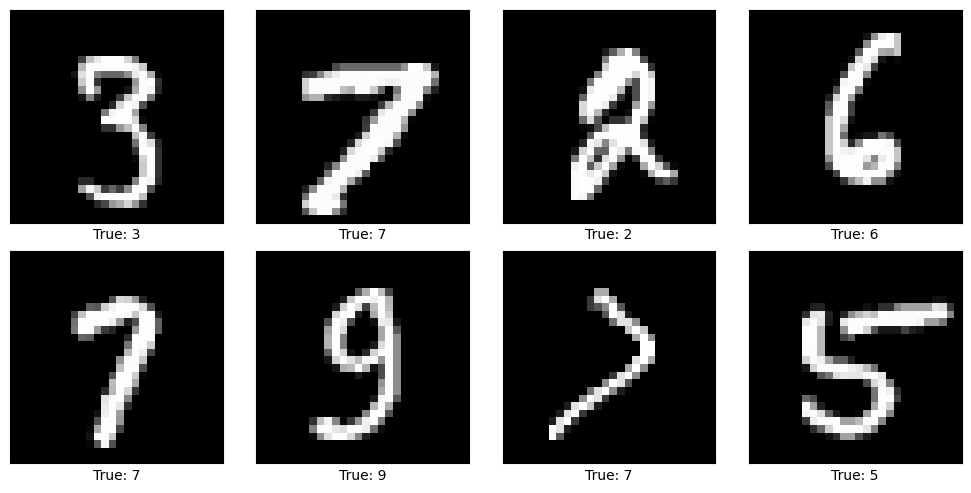

In [29]:
(X_train, y_train), (X_test, y_test) = datasets.mnist.load_data()
plot_data(X_train, y_train)

##### 4.1. Preprocessing the data

In [30]:
# Normalize the data
X_train = X_train.reshape(len(X_train), 1, 28, 28)
X_test = X_test.reshape(len(X_test), 1, 28, 28)

In [31]:
# Convert to [0, 1] range
X_train = X_train.astype("float32") / 255
X_test = X_test.astype("float32") / 255

In [32]:
# One-hot encode the labels
y_train = np.eye(10)[y_train]
y_test = np.eye(10)[y_test]

# Reshape the labels
y_train = y_train.reshape(len(y_train), 10, 1)
y_test = y_test.reshape(len(y_test), 10, 1)

##### 4.2. Training the model

In [33]:
model = CNN(
    [
        Conv2D((1, 28, 28), 3, 5),
        Activation(act_type="sigmoid"),
        Reshape((5, 26, 26), (5 * 26 * 26, 1)),
        Dense(5 * 26 * 26, 100),
        Activation(act_type="sigmoid"),
        Dense(100, 10),
        Activation(act_type="sigmoid"),
    ]
)

model.compile(cost_type="cross_entropy", lr=0.01)

In [34]:
model.summary()

Model: CNN
--------------------------------------------------------------------------------------
Layer (type)                                 Output Shape              Param #        
conv2d_1 (Conv2D)                            (5, 1, 3, 3)              45
activation_1 (Activation)                                                         
reshape_1 (Reshape)                          (3380, 1)                 3380
dense_1 (Dense)                              (100, 3380)               338000
activation_2 (Activation)                                                         
dense_2 (Dense)                              (10, 100)                 1000
activation_3 (Activation)                                                         
Total params: 342425
Cost function: cross_entropy
Learning rate: 0.01
Verbose: True
--------------------------------------------------------------------------------------


In [35]:
model.fit(X_train, y_train, epochs=15)

Epoch 1/15


100%|██████████| 60000/60000 [01:13<00:00, 811.57it/s]


Cost: 0.2874, Accuracy: 0.3405
Epoch 2/15


100%|██████████| 60000/60000 [01:17<00:00, 779.18it/s]


Cost: 0.2462, Accuracy: 0.4528
Epoch 3/15


100%|██████████| 60000/60000 [01:16<00:00, 785.50it/s]


Cost: 0.2159, Accuracy: 0.5544
Epoch 4/15


100%|██████████| 60000/60000 [01:14<00:00, 804.76it/s]


Cost: 0.1889, Accuracy: 0.6265
Epoch 5/15


100%|██████████| 60000/60000 [01:15<00:00, 797.12it/s]


Cost: 0.1769, Accuracy: 0.6567
Epoch 6/15


100%|██████████| 60000/60000 [01:13<00:00, 814.87it/s]


Cost: 0.1719, Accuracy: 0.6629
Epoch 7/15


100%|██████████| 60000/60000 [01:12<00:00, 826.68it/s]


Cost: 0.1695, Accuracy: 0.6724
Epoch 8/15


100%|██████████| 60000/60000 [01:12<00:00, 824.98it/s]


Cost: 0.1488, Accuracy: 0.7280
Epoch 9/15


100%|██████████| 60000/60000 [01:11<00:00, 833.84it/s]


Cost: 0.1337, Accuracy: 0.7624
Epoch 10/15


100%|██████████| 60000/60000 [01:11<00:00, 835.88it/s]


Cost: 0.1198, Accuracy: 0.7939
Epoch 11/15


100%|██████████| 60000/60000 [01:10<00:00, 847.11it/s]


Cost: 0.1085, Accuracy: 0.8169
Epoch 12/15


100%|██████████| 60000/60000 [01:12<00:00, 833.09it/s]


Cost: 0.1007, Accuracy: 0.8326
Epoch 13/15


100%|██████████| 60000/60000 [01:11<00:00, 833.66it/s]


Cost: 0.0952, Accuracy: 0.8428
Epoch 14/15


100%|██████████| 60000/60000 [01:10<00:00, 848.35it/s]


Cost: 0.0907, Accuracy: 0.8520
Epoch 15/15


100%|██████████| 60000/60000 [01:10<00:00, 845.48it/s]

Cost: 0.0869, Accuracy: 0.8588


##### 4.3. Model results

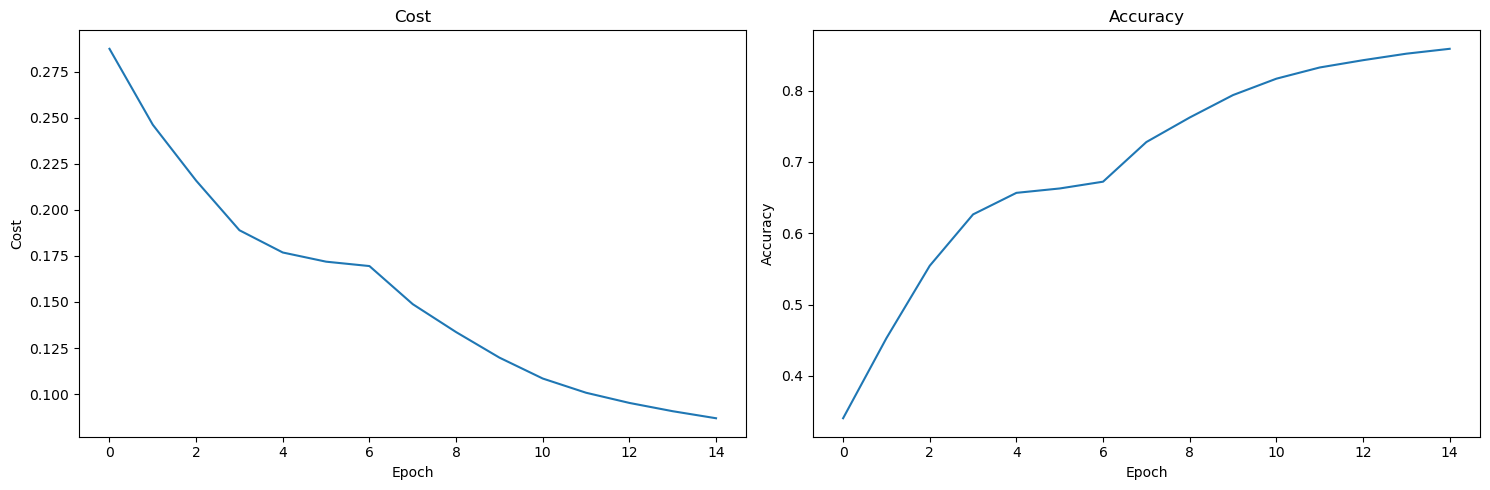

In [36]:
model.plot_history()

In [37]:
y_pred = model.predict(X_test)

print(f"Accuracy: {np.mean(np.argmax(y_pred, axis=1) == np.argmax(y_test, axis=1))}")

Accuracy: 0.8617


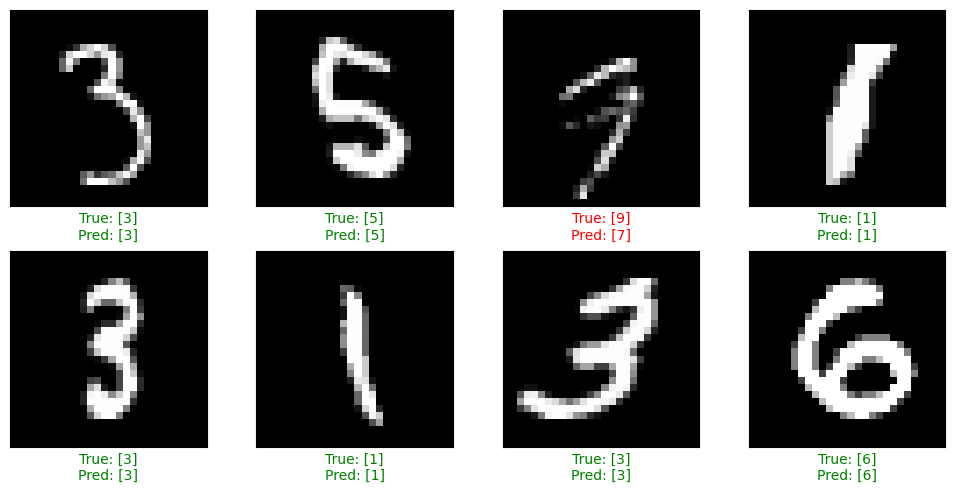

In [38]:
plot_data(
    X_test.reshape(len(X_test), 28, 28),
    np.argmax(y_test, axis=1),
    np.argmax(y_pred, axis=1),
)